In [ ]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
class Restaurant:
  def __init__(self, name, description, location, price):
    self.name = name
    self.description = description
    self.location = location
    self.price = price
  def __str__(self):
    return self.name
  def __repr__(self):
    return self.name

In [ ]:
class User:
    def __init__(self, location, price_preference, category_preferences=None):
        self.location = location
        self.price_preference = price_preference
        self.category_preferences = category_preferences

    def randomize_preferences(self, categories):
        self.category_preferences = np.random.choice(categories, 3,
                                                     replace=False)

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import random

#Initialize our test restaurants
names = ['Chipotle', 'Alpaca', 'Cosmic Cantina', 'Guasaca', 'Monuts',
         'Heavenly Buffalos', 'Nothing']
descriptions = ["Fast-food chain offering Mexican fare, including design-your-own burritos, tacos & bowls.",
  "Local counter-serve chain featuring a menu of Peruvian-style rotisserie chicken & Latin sides.",
  "Organic Mexican eats plus beer & margaritas served in casual, cozy digs with very late-night hours.",
  "Colorful counter-serve hub doling out custom-made arepas, bowls & salads in a chic, bright space.",
  "Busy joint dispensing handmade gourmet donuts, sandwiches on house-baked bagels, coffee & beer.",
  "Casual hub for chicken & vegan wings tossed in a variety of sauces at every spice level.",
  "blah blah blah hey now blah."]
#(latitude, longitude)
restaurant_locations = [(36.008767, -78.944303), (36.007797, -78.922274),
 (36.0077961, -78.9218492), (36.006812, -78.924576), (36.0139103, -78.9215285),
  (36.0066658, -78.9477924), (0,0)]

restaurants = []

for i in range(len(names)):
  restaurants.append(Restaurant(names[i], descriptions[i],
                                restaurant_locations[i], random.randint(1,4)))




model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


In [ ]:
#calculate similarity scores from categories and restaurants nearby
def calc_score(restaurants, users):
  scores = [0 for row in range(len(restaurants))]
  #category matching
  for user in users:
    for category in user.category_preferences:
      for ind, restaurant in enumerate(restaurants):
        #embed each of the categories and the descriptions using the model
        embedding_1= model.encode(category, convert_to_tensor=True)
        embedding_2 = model.encode(restaurant.description,
                                   convert_to_tensor=True)

        #measure the similarity between categories and descriptions
        #using a cosine similarity
        score = util.pytorch_cos_sim(embedding_1, embedding_2)
        scores[ind] += score

  #location matching
  restaurant_squared_distances=[0 for restaurant in restaurants]
  for ind, restaurant in enumerate(restaurants):
    for user in users:
      long_dist = (restaurant.location[0] - user.location[0])**2
      lat_dist = (restaurant.location[1] - user.location[1])**2
      restaurant_squared_distances[ind] += long_dist + lat_dist

  #If a restaurant is in the upper quartile of distances (far-awayness),
  #we penalize its score
  upper_quartile = np.percentile(restaurant_squared_distances, 75)
  for ind in range(len(restaurant_squared_distances)):
    if restaurant_squared_distances[ind] > upper_quartile:
      #Penalization factor has value of
      #(75 percentile squared distance/restaurant squared distance)
      penalization = (upper_quartile / restaurant_squared_distances[ind])
      scores[ind] = scores[ind]*penalization

  print(restaurant_squared_distances)
  #price matching
  for ind, restaurant in enumerate(restaurants):
    price_penalty = 0
    for user in users:
      #only penalize if price is higher than desired
      if restaurant.price > user.price_preference:
        price_penalty += restaurant.price - user.price_preference
    price_penalty = price_penalty/len(users)
    scores[ind] = scores[ind]/(1 + price_penalty)



  return scores

In [ ]:
#Initialize our test users
categories = ['burgers', 'tacos', 'chinese', 'dessert', 'salads', 'bakeries', 'vegan', 'brunch',
              'bar', 'mexican', 'chicken']
price_preferences = [2, 1, 3, 2]

#location: Duke chapel
user1 = User(location=(36.0018681, -78.9402861),
             price_preference=price_preferences[0])
user1.randomize_preferences(categories)

#location: Southgate (East campus)
user2 = User(location=(36.0060313, -78.9181483),
             price_preference=price_preferences[1])
user2.randomize_preferences(categories)

#location: Erwin Mill (on 9th street)
user3 = User(location=(36.008782, -78.922188),
             price_preference=price_preferences[2])
user3.randomize_preferences(categories)

#location: West Village (downtown Durham)
user4 = User(location=(35.998501, -78.9071795),
             price_preference=price_preferences[3])
user4.randomize_preferences(categories)

users = [user1, user2, user3, user4]

scores = calc_score(restaurants, users)
print(scores)
best_index = np.argmax(scores)
best_restaurant = restaurants[best_index]

print("Optimal restaurant for the group is:")
print(f"- {best_restaurant.name}: {best_restaurant.description}")

[0.002727901151650899, 0.0006949638658497816, 0.0006945574118098954, 0.0006944685862498458, 0.001040441260269918, 0.0033346729272895, 30099.790888040112]
[tensor([[1.3160]]), tensor([[3.1330]]), tensor([[0.8398]]), tensor([[1.0702]]), tensor([[1.4030]]), tensor([[2.8797]]), tensor([[7.0061e-08]])]
Optimal restaurant for the group is:
- Alpaca: Local counter-serve chain featuring a menu of Peruvian-style rotisserie chicken & Latin sides.


In [ ]:
recommendations = [x for _,x in sorted(zip(scores,restaurants),
                                       reverse = True)]

In [ ]:
print("The recommendations in order is:")
for i in recommendations:
  print(i)

The recommendations in order is:
Alpaca
Heavenly Buffalos
Monuts
Chipotle
Guasaca
Cosmic Cantina
Nothing


In [ ]:
# Each user's price point and preferences for this run
for user in users:
  print(user.price_preference, user.category_preferences)

2 ['dessert' 'vegan' 'burgers']
1 ['vegan' 'chicken' 'bar']
3 ['chinese' 'dessert' 'bakeries']
2 ['bakeries' 'mexican' 'chicken']


In [ ]:
scores = torch.stack(scores).squeeze()

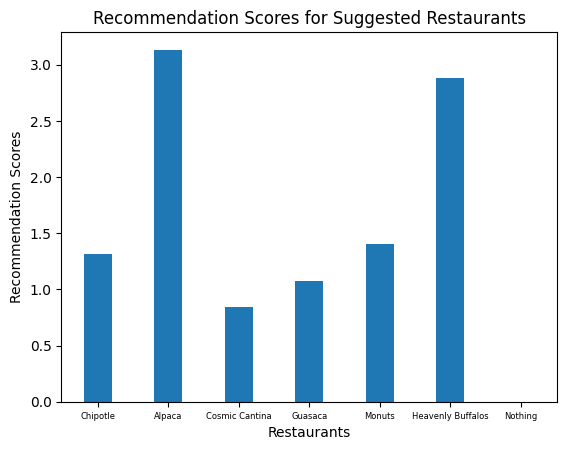

In [ ]:
import matplotlib.pyplot as plt
import torch
restaurant_names = [x.name for x in restaurants]
plt.bar(restaurant_names, scores, width = 0.4)

plt.xlabel("Restaurants")
plt.ylabel("Recommendation Scores")
plt.title("Recommendation Scores for Suggested Restaurants")
plt.xticks(fontsize = 6)
plt.show()

Second Run

In [ ]:
names = ['Chipotle', 'Alpaca', 'Cosmic Cantina', 'Guasaca', 'Monuts',
         'Heavenly Buffalos', 'Nothing']
descriptions = ["Fast-food chain offering Mexican fare, including design-your-own burritos, tacos & bowls.",
  "Local counter-serve chain featuring a menu of Peruvian-style rotisserie chicken & Latin sides.",
  "Organic Mexican eats plus beer & margaritas served in casual, cozy digs with very late-night hours.",
  "Colorful counter-serve hub doling out custom-made arepas, bowls & salads in a chic, bright space.",
  "Busy joint dispensing handmade gourmet donuts, sandwiches on house-baked bagels, coffee & beer.",
  "Casual hub for chicken & vegan wings tossed in a variety of sauces at every spice level.",
  "blah blah blah hey now blah."]

#(latitude, longitude)
restaurant_locations = [(36.008767, -78.944303), (36.007797, -78.922274),
 (36.0077961, -78.9218492), (36.006812, -78.924576), (36.0139103, -78.9215285),
  (36.0066658, -78.9477924), (0,0)]

restaurants = []

for i in range(len(names)):
  restaurants.append(Restaurant(names[i], descriptions[i],
                                restaurant_locations[i], random.randint(1,4)))

In [ ]:
categories = ['burgers', 'tacos', 'chinese', 'dessert', 'salads',
              'bakeries', 'vegan', 'brunch','bar', 'mexican', 'chicken']
price_preferences = [2, 1, 3, 2]

#location: Duke chapel
user1 = User(location=(36.0018681, -78.9402861),
             price_preference=price_preferences[0])
user1.randomize_preferences(categories)

#location: Southgate (East campus)
user2 = User(location=(36.0060313, -78.9181483),
             price_preference=price_preferences[1])
user2.randomize_preferences(categories)

#location: Erwin Mill (on 9th street)
user3 = User(location=(36.008782, -78.922188),
             price_preference=price_preferences[2])
user3.randomize_preferences(categories)

#location: West Village (downtown Durham)
user4 = User(location=(35.998501, -78.9071795),
             price_preference=price_preferences[3])
user4.randomize_preferences(categories)

users = [user1, user2, user3, user4]

scores = calc_score(restaurants, users)
print(scores)
best_index = np.argmax(scores)
best_restaurant = restaurants[best_index]

print("Optimal restaurant for the group is:")
print(f"- {best_restaurant.name}: {best_restaurant.description}")

[0.002727901151650899, 0.0006949638658497816, 0.0006945574118098954, 0.0006944685862498458, 0.001040441260269918, 0.0033346729272895, 30099.790888040112]
[tensor([[2.5464]]), tensor([[1.5648]]), tensor([[0.9794]]), tensor([[1.9632]]), tensor([[3.4376]]), tensor([[0.9145]]), tensor([[1.4193e-07]])]
Optimal restaurant for the group is:
- Monuts: Busy joint dispensing handmade gourmet donuts, sandwiches on house-baked bagels, coffee & beer.


In [ ]:
recommendations = [x for _,x in sorted(zip(scores,restaurants),
                                       reverse = True)]

In [ ]:
print("The recommendations in order is:")
for i in recommendations:
  print(i)

The recommendations in order is:
Monuts
Chipotle
Guasaca
Alpaca
Cosmic Cantina
Heavenly Buffalos
Nothing


In [ ]:
# Each user's price point and preferences for this run
for user in users:
  print(user.price_preference, user.category_preferences)

2 ['burgers' 'chinese' 'bakeries']
1 ['tacos' 'bakeries' 'vegan']
3 ['salads' 'burgers' 'dessert']
2 ['brunch' 'bar' 'mexican']


In [ ]:
scores = torch.stack(scores).squeeze()

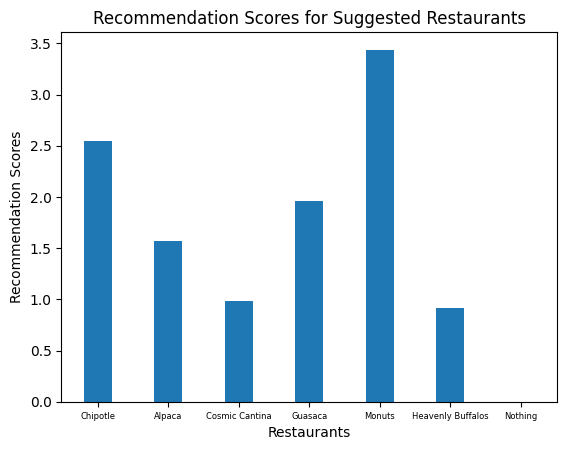

In [ ]:
import matplotlib.pyplot as plt
import torch
restaurant_names = [x.name for x in restaurants]
plt.bar(restaurant_names, scores, width = 0.4)

plt.xlabel("Restaurants")
plt.ylabel("Recommendation Scores")
plt.title("Recommendation Scores for Suggested Restaurants")
plt.xticks(fontsize = 6)
plt.show()